## Bayesian Network Inference for Obesity Risk Analysis

In this problem, I use the ``bnlearn`` package to learn the structure of a causal graphical model from data, parameterize the graph, i.e., learn the values of the conditional probability distributions (CPDs), and perform inference using the learned model.

I used a dataset from the UCI repository. Here's the link: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

In [ ]:
!pip install bnlearn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
import numpy as np
import bnlearn as bn
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(0)

In [ ]:
data = pd.read_csv("obesity_data.csv")
data.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [ ]:
data['Activity Level'] = pd.cut(x=data["FAF"], bins=[-1,0.5,1.5,2.5,3.5],
                               labels=["No activity","1 or 2 days","2 or 4 days","4 or 5 days"])
data['Veggie Intake'] = pd.cut(x=data["FCVC"], bins=[0.5,1.5,2.5,3.5],
                               labels=["Never","Sometimes","Always"])

data['No. Main Meals'] = pd.cut(x=data["NCP"], bins=[0.5,2.0,3.5,4.5],
                               labels=["Between 1 and 2","Three","More than three"])

data['H2O Intake'] = pd.cut(x=data["CH2O"], bins=[0.5,1.5,2.5,3.5],
                               labels=["Less than 1L","Between 1L and 2L","More than 2L"])

data['Tech Use'] = pd.cut(x=data["TUE"], bins=[-0.5,0.5,1.5,2.5],
                               labels=["0-2 Hours","3-5 Hours","More than 5 hours"])

# These labels and bins were created independently from the paper
data['Binned Age'] = pd.cut(x=data['Age'], bins=[0, 3, 18, 63, 99],
                            labels=['Baby', 'Child', 'Adult', 'Elderly'])
data['Binned Height'] = pd.cut(x=data["Height"], bins=[0,1.6,1.8,2.5], # meters
                               labels=["Short","Medium","Tall"])
data["Binned Obesity Level"] = data["NObeyesdad"].apply(lambda x: "Insufficient" if 'Insufficient' in x else \
 ("Normal" if 'Normal' in x else ("Overweight" if "Overweight" in x else "Obese")))

In [ ]:
data_subset = data.loc[:, (data.nunique() < 8).values]
data_subset.drop(columns=["SMOKE","FAVC",], inplace=True)
data_subset.rename(columns={"CAEC": "Food Between Meals", "SCC": "Monitor Calories", "CALC": "Alcohol Intake", "MTRANS": "Transportation", "NObeyesdad": "Obesity Level"}, inplace=True)

data_subset_bin = data_subset.drop(columns=["Obesity Level"]).rename(columns={"Binned Obesity Level":"Obesity Level"})
data_subset = data_subset.drop(columns=["Binned Obesity Level"])

# data_subset.describe(include="all")

In [ ]:
# Here are the possible values for each variable
for i in data_subset:
  print(i, ": ", data_subset[i].unique())

Gender :  ['Female' 'Male']
family_history_with_overweight :  ['yes' 'no']
Food Between Meals :  ['Sometimes' 'Frequently' 'Always' 'no']
Monitor Calories :  ['no' 'yes']
Alcohol Intake :  ['no' 'Sometimes' 'Frequently' 'Always']
Transportation :  ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity Level :  ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']
Activity Level :  ['No activity', '4 or 5 days', '2 or 4 days', '1 or 2 days']
Categories (4, object): ['No activity' < '1 or 2 days' < '2 or 4 days' < '4 or 5 days']
Veggie Intake :  ['Sometimes', 'Always', 'Never']
Categories (3, object): ['Never' < 'Sometimes' < 'Always']
No. Main Meals :  ['Three', 'Between 1 and 2', 'More than three']
Categories (3, object): ['Between 1 and 2' < 'Three' < 'More than three']
H2O Intake :  ['Between 1L and 2L', 'More than 2L', 'Less than 1L']
Categories (3, object): ['Less than 1L' < 'B

The bnlearn library has a method for learning the structure of a graphical model describing the dependencies across variables. Here, I use `bn.structure_learning` to learn the DAG. Then use `bn.plot_graphviz(DAG)` function to plot the learned DAG.


[bnlearn] >Warning: Computing DAG with 14 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]


[06-05-2025 23:26:49] [setgraphviz.setgraphviz] [INFO] The OS is not supported to automatically set Graphviz in the system env.
[06-05-2025 23:26:49] [setgraphviz.setgraphviz] [INFO] Graphviz path found in environment.


[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


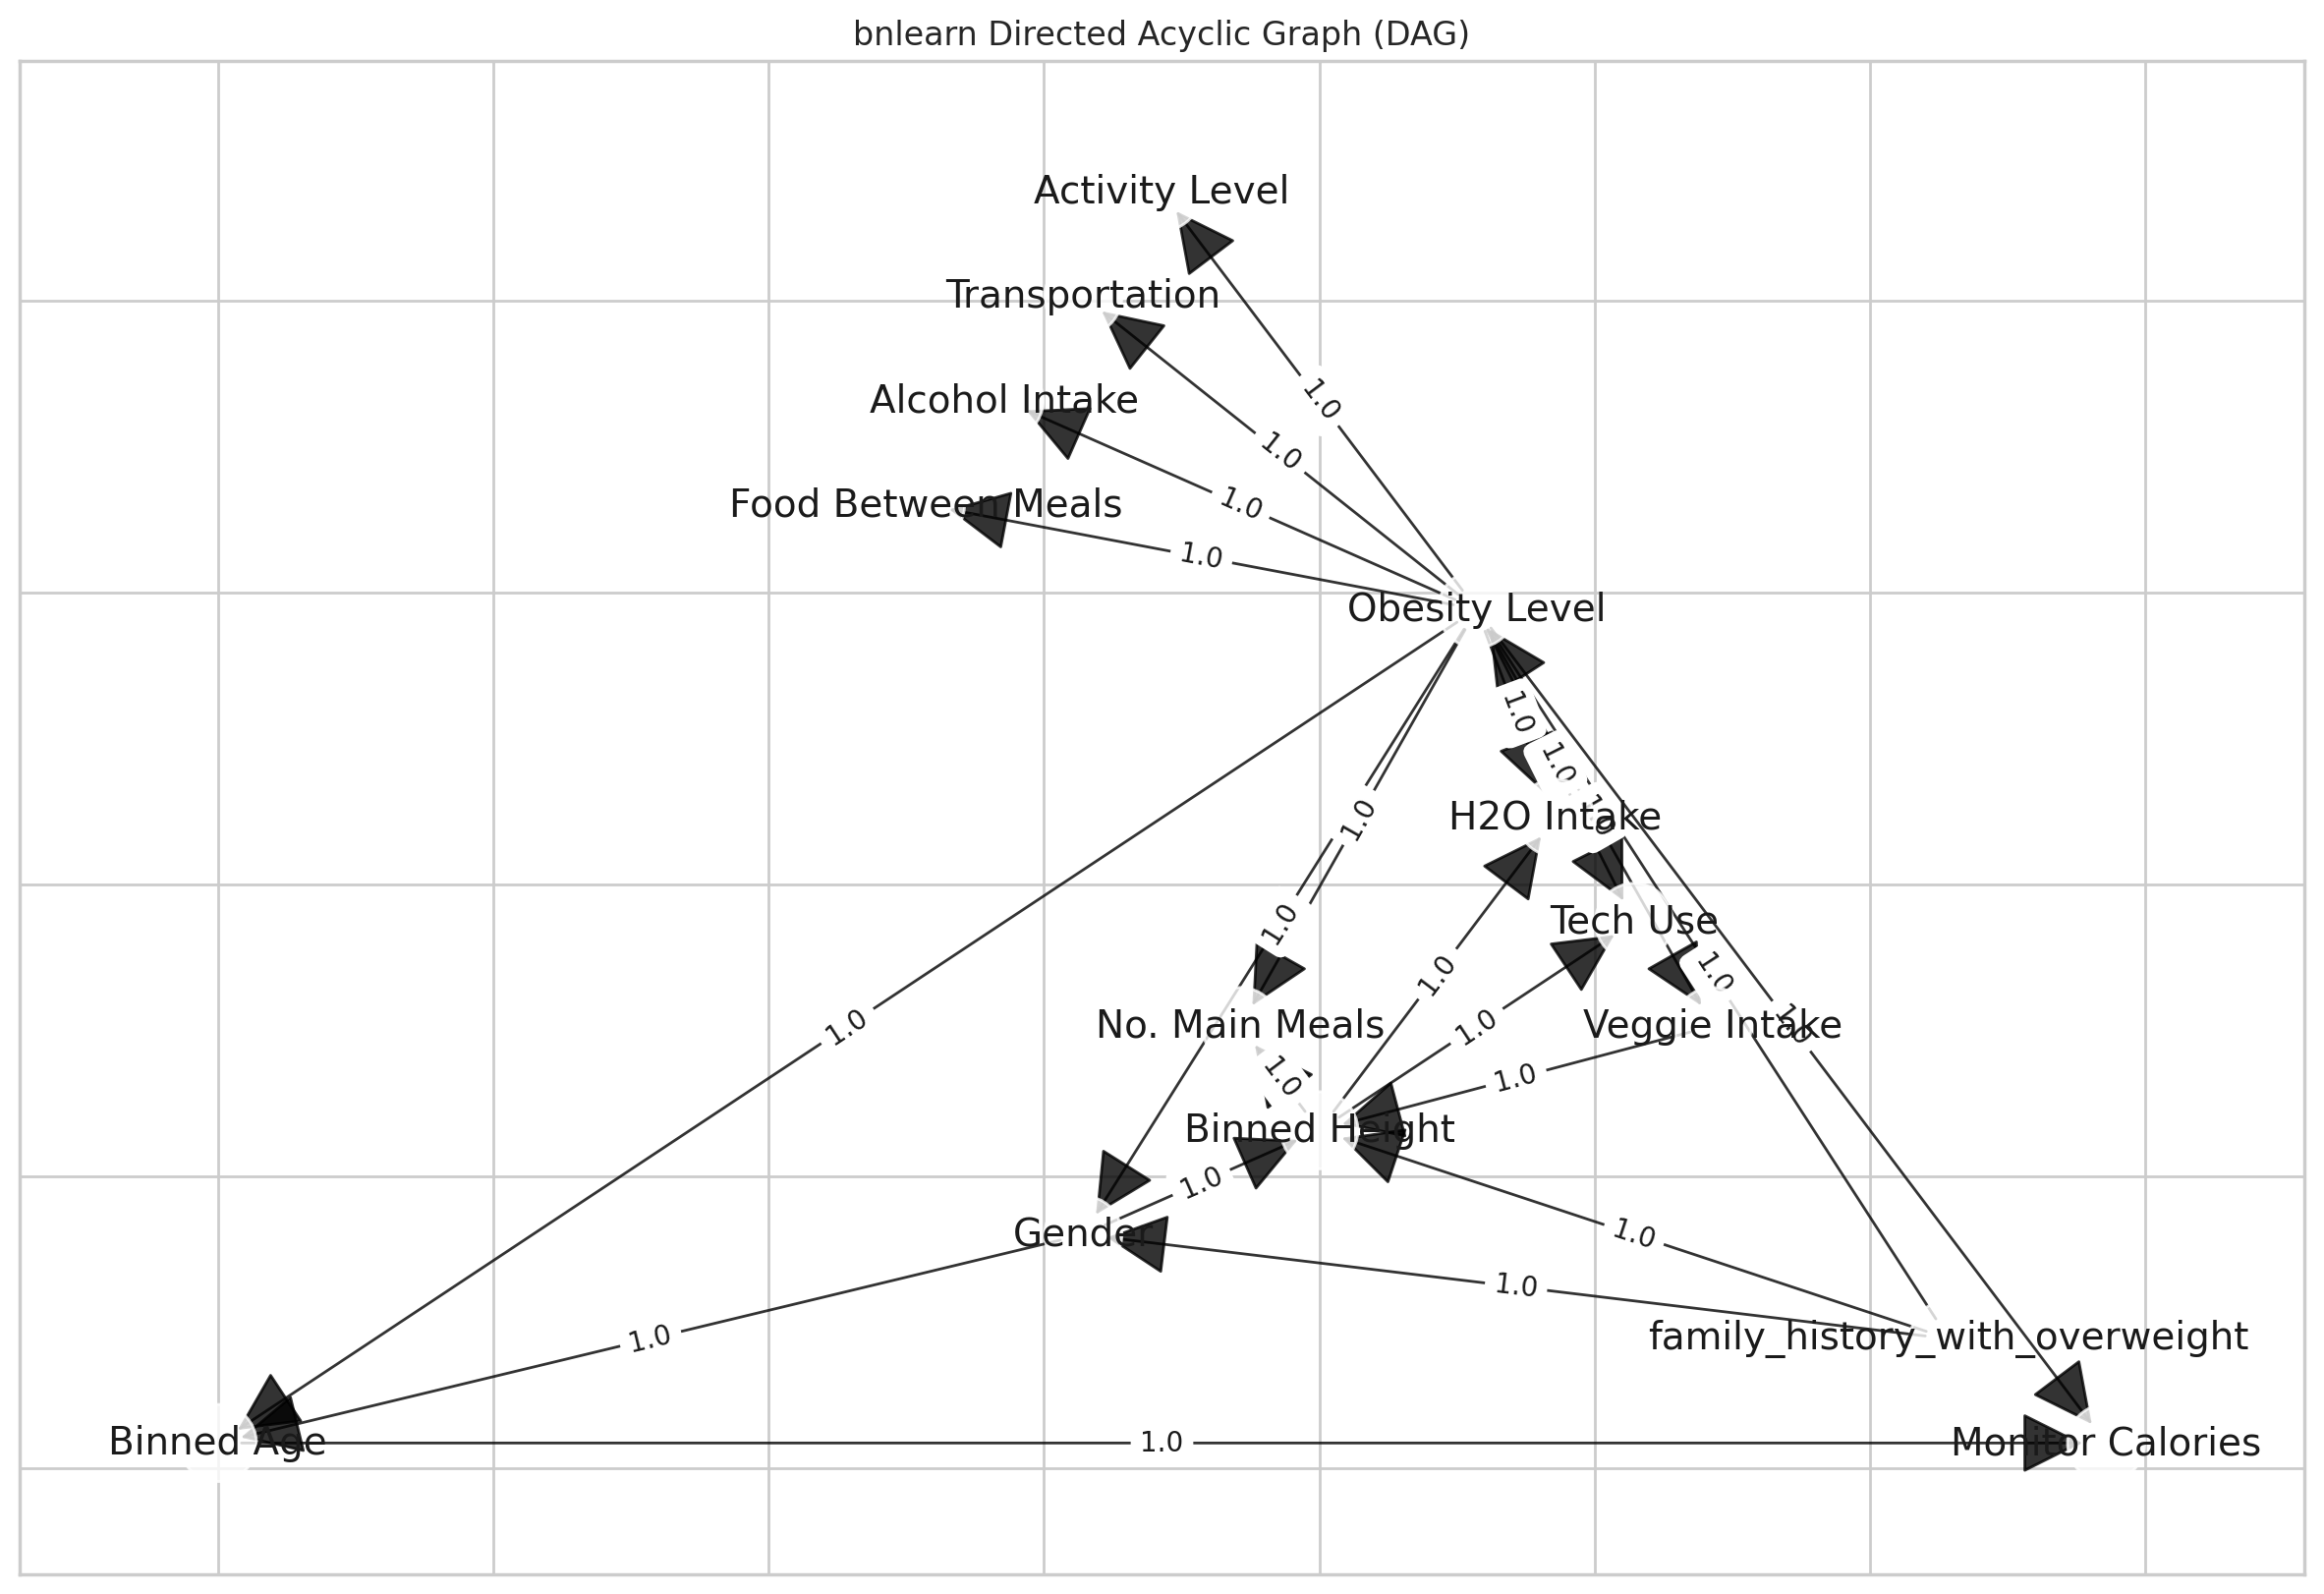

In [ ]:
random.seed(0)
model = bn.structure_learning.fit(data_subset)
bn.plot_graphviz(model)
try:
    bn.plot_graphviz(model,
                    node_color='white',
                    params_static={'layout':'planar_layout', 'arrowsize': 50})
except:
    bn.plot(model, #in case graphviz doesnt work
           node_color='white',
           params_static={'layout':'planar_layout', 'arrowsize': 50})

Next, I display the learned DAG as an adjacency matrix.


In [ ]:
edges = model['model'].edges()

nodes = sorted(list(model['model'].nodes()))

adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes)

for parent, child in edges:
    adj_matrix.loc[parent, child] = 1

print(adj_matrix)


                                Activity Level  Alcohol Intake  Binned Age  \
Activity Level                               0               0           0   
Alcohol Intake                               0               0           0   
Binned Age                                   0               0           0   
Binned Height                                0               0           0   
Food Between Meals                           0               0           0   
Gender                                       0               0           1   
H2O Intake                                   0               0           0   
Monitor Calories                             0               0           0   
No. Main Meals                               0               0           0   
Obesity Level                                1               1           1   
Tech Use                                     0               0           0   
Transportation                               0               0  

Here, I use `parameter_learning.fit` to estimate the parameters of the graphical model using the `bayes` method. I store the conditional probability distributions learned for the variables in my graph using `bn.print_CPD` into an object named `CPDs`.


In [ ]:
# Part 3 Solution

model = bn.parameter_learning.fit(model, data_subset, methodtype='bayes', verbose=0)

CPDs = bn.print_CPD(model, verbose=0)



Using the CPDs object I saved from earlier, I can compute many different probabilities/distributions of different variables, such as Obesity Level, Activity Level, Food between Meals, etc. This can be helpful in determining different correlations between Obesity and other variables/factors.

For example:
1. Probability that a person is considered normal weight given that they eat frequently between meals?
2. Probability distribution P(**Activity Level** | Obesity Level=Obesity_Type_III)? Hint: Your answer should be a vector of probabilities
3. Probability that a person is female given they are considered to have insufficient weight and no family history of overweight problems?

In [ ]:
# 1. 
q1 = bn.inference.fit(model,
                      variables=['Obesity Level'],
                      evidence={'Food Between Meals': 'Frequently'},
                      verbose=0)
print(q1)

# 2. 
q2 = bn.inference.fit(model,
                      variables=['Activity Level'],
                      evidence={'Obesity Level': 'Obesity_Type_III'},
                      verbose=0)
print(q2)

# 3.
q3 = bn.inference.fit(model,
                      variables=['Gender'],
                      evidence={'Obesity Level': 'Insufficient_Weight',
                                'family_history_with_overweight': 'no'},
                      verbose=0)
print(q3)

+------------------------------------+----------------------+
| Obesity Level                      |   phi(Obesity Level) |
+====================================+======================+
| Obesity Level(Insufficient_Weight) |               0.3185 |
+------------------------------------+----------------------+
| Obesity Level(Normal_Weight)       |               0.2413 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_I)      |               0.0848 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_II)     |               0.0746 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_III)    |               0.0746 |
+------------------------------------+----------------------+
| Obesity Level(Overweight_Level_I)  |               0.1010 |
+------------------------------------+----------------------+
| Obesity Level(Overweight_Level_II) |               0.1051 |
+-------

1. The probability that a person is Normal Weight given they eat frequently between meals is 0.2413.
2. The conditional distribution P(Activity Level | Obesity Level = Obesity_Type_III) is:

    1 or 2 days: 0.2222

    2 or 4 days: 0.2243

    4 or 5 days: 0.0765

    No activity: 0.4771

3. The probability that a person is female given they have Insufficient Weight and no family history of overweight is 0.7576.

Some probabilities we are interested in aren't directly captured by the CPDs and require Bayes' Rule to compute. I use `bn.inference.fit` to perform inference on the graph and compute the probabilities of other conditional probabilities, such as:

- The probability of a person being class III obese, given their transportation is usually walking?
- The probability of a person being normal weight given they use technological devices for less than 2 hours a day and they drink between 1 and 2 liters of water per day?
- The probability that someone frequently consumes food between meals given they monitor their calories and they are considered to have insufficient weight?
- The probability distribution P(**family_history_with_overweight**, **Gender** | Alcohol="Always")? Hint: the answer should be a vector with a label for each value


In [ ]:
q1 = bn.inference.fit(model,
                      variables=['Obesity Level'],
                      evidence={'Transportation': 'Walking'},
                      verbose=0)
print(q1)

q2 = bn.inference.fit(model,
                      variables=['Obesity Level'],
                      evidence={'Tech Use': '0-2 Hours', 'H2O Intake': 'Between 1L and 2L'},
                      verbose=0)
print(q2)

q3 = bn.inference.fit(model,
                      variables=['Food Between Meals'],
                      evidence={'Monitor Calories': 'yes', 'Obesity Level': 'Insufficient_Weight'},
                      verbose=0)
print(q3)

q4 = bn.inference.fit(model,
                      variables=['family_history_with_overweight', 'Gender'],
                      evidence={'Alcohol Intake': 'Always'},
                      verbose=0)
print(q4)



+------------------------------------+----------------------+
| Obesity Level                      |   phi(Obesity Level) |
+====================================+======================+
| Obesity Level(Insufficient_Weight) |               0.1350 |
+------------------------------------+----------------------+
| Obesity Level(Normal_Weight)       |               0.2366 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_I)      |               0.1194 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_II)     |               0.1155 |
+------------------------------------+----------------------+
| Obesity Level(Obesity_Type_III)    |               0.1116 |
+------------------------------------+----------------------+
| Obesity Level(Overweight_Level_I)  |               0.1468 |
+------------------------------------+----------------------+
| Obesity Level(Overweight_Level_II) |               0.1350 |
+-------

1. From the table, P(Obesity Level = Obesity_Type_III | Transportation = Walking) = 0.1116
2. From the table, P(Obesity Level = Normal_Weight | Tech Use < 2 hrs/day, H2O Intake = 1–2 L/day) = 0.1446.
3. From the data, P(Food Between Meals = Frequently | Monitor Calories = Yes, Obesity Level = Insufficient_Weight) = 0.3778.
4.  P(family_history_with_overweight, Gender | Alcohol Intake = Always):

    no, Female: 0.1594

    no, Male: 0.1317

    yes, Female: 0.3347

    yes, Male: 0.3742

**Using the CPD** for Activity Level, I created a plot showing the relationship between Activity Level and Obesity Level.

I also plotted the different Obesity Level classes on the x-axis, had a line for each Activity Level, and had the probability that a particular Activity Level occurs given the Obesity Level on the y-axis.

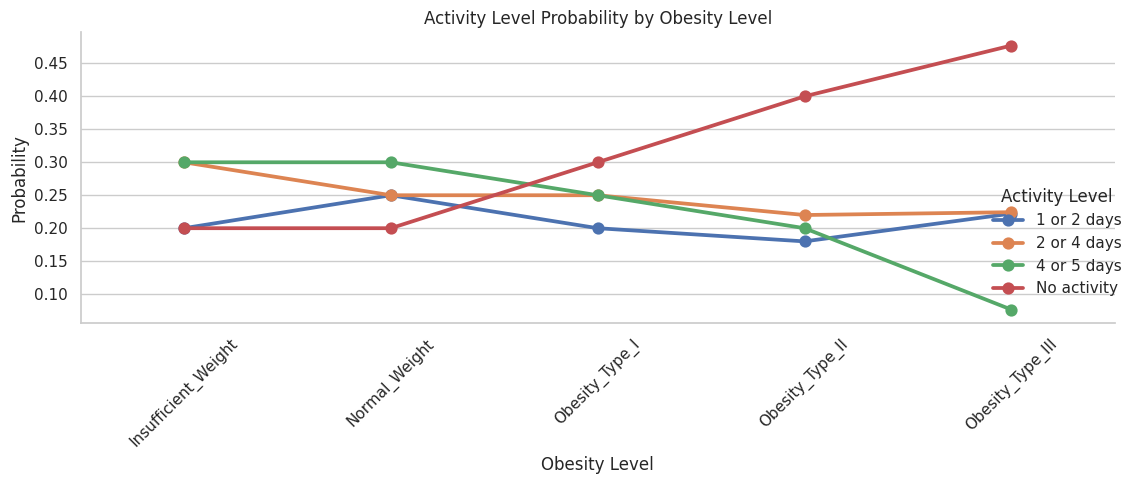

In [ ]:
data = {
    'Obesity Level': [
        'Insufficient_Weight', 'Insufficient_Weight', 'Insufficient_Weight', 'Insufficient_Weight',
        'Normal_Weight', 'Normal_Weight', 'Normal_Weight', 'Normal_Weight',
        'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I', 'Obesity_Type_I',
        'Obesity_Type_II', 'Obesity_Type_II', 'Obesity_Type_II', 'Obesity_Type_II',
        'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III',
    ],
    'Activity Level': [
        '1 or 2 days', '2 or 4 days', '4 or 5 days', 'No activity',
        '1 or 2 days', '2 or 4 days', '4 or 5 days', 'No activity',
        '1 or 2 days', '2 or 4 days', '4 or 5 days', 'No activity',
        '1 or 2 days', '2 or 4 days', '4 or 5 days', 'No activity',
        '1 or 2 days', '2 or 4 days', '4 or 5 days', 'No activity',
    ],
    'Probability': [
        0.2, 0.3, 0.3, 0.2,
        0.25, 0.25, 0.3, 0.2,
        0.2, 0.25, 0.25, 0.3,
        0.18, 0.22, 0.2, 0.4,
        0.2222, 0.2243, 0.0765, 0.4771
    ]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plot = sns.catplot(data=df,
                   x="Obesity Level",
                   y="Probability",
                   hue="Activity Level",
                   kind="point",
                   aspect=2,
                   height=5)
plot.set_xticklabels(rotation=45)
plt.title("Activity Level Probability by Obesity Level")
plt.tight_layout()
plt.show()


From this plot, some insights that we can draw are that No Activity increases with higher obesity levels. For individuals with Obesity_Type_III, nearly half report no physical activity, showing a very strong relationship between inactivity and severe obesity. Also, the "4 or 5 days" activity level declines as obesity increases. It starts as the most common activity level for those with Insufficient_Weight and Normal_Weight but drops to under 10% for Obesity_Type_III, which suggests a strong inverse relationship between regular activity and obesity severity. Lastly, the transition point in the plot appears around Obesity_Type_I, where physical inactivity overtakes regular activity as the most likely behavior, which also sugggests a critical change in health behavior patterns.

Here, instead of using the CPD for activity level which tells us what the probability is that someone has a specific activity level given they their obesity classification, I used Bayes' rule to get another probability: the probability that someone is of a particular obesity level given they their activity level.

In [ ]:
dag = model

q1 = bn.inference.fit(dag, variables=["Obesity Level"], evidence={"Activity Level":"No activity"}, verbose=0)
q2 = bn.inference.fit(dag, variables=["Obesity Level"], evidence={"Activity Level":"1 or 2 days"}, verbose=0)
q3 = bn.inference.fit(dag, variables=["Obesity Level"], evidence={"Activity Level":"2 or 4 days"}, verbose=0)
q4 = bn.inference.fit(dag, variables=["Obesity Level"], evidence={"Activity Level":"4 or 5 days"})

[bnlearn] >Variable Elimination.
+----+---------------------+-----------+
|    | Obesity Level       |         p |
+====+=====================+===========+
|  0 | Insufficient_Weight | 0.126597  |
+----+---------------------+-----------+
|  1 | Normal_Weight       | 0.207898  |
+----+---------------------+-----------+
|  2 | Obesity_Type_I      | 0.164537  |
+----+---------------------+-----------+
|  3 | Obesity_Type_II     | 0.0967867 |
+----+---------------------+-----------+
|  4 | Obesity_Type_III    | 0.0967867 |
+----+---------------------+-----------+
|  5 | Overweight_Level_I  | 0.161827  |
+----+---------------------+-----------+
|  6 | Overweight_Level_II | 0.145567  |
+----+---------------------+-----------+

Summary for variables: ['Obesity Level']
Given evidence: Activity Level=4 or 5 days

Obesity Level outcomes:
- Obesity Level: Insufficient_Weight (12.7%)
- Obesity Level: Normal_Weight (20.8%)
- Obesity Level: Obesity_Type_I (16.5%)
- Obesity Level: Obesity_Type_II (9.

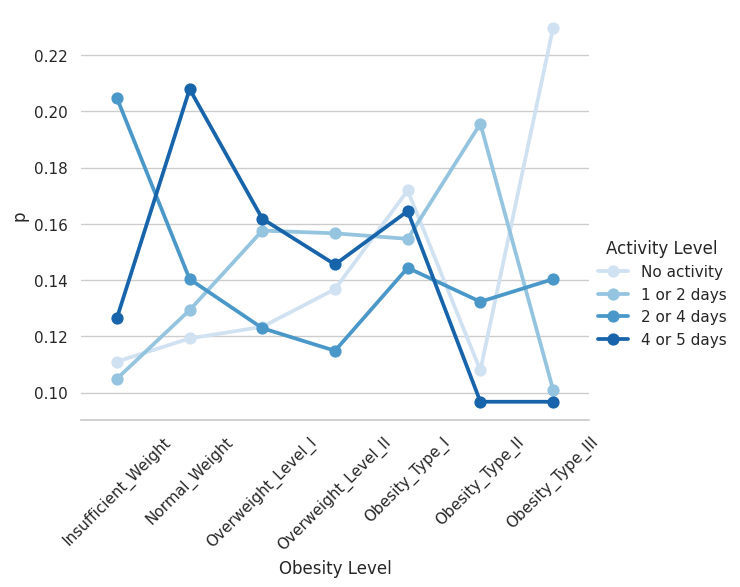

In [ ]:
q6_df=pd.concat([q1.df,q2.df,q3.df,q4.df])
q6_df['Activity Level'] = np.repeat(['No activity','1 or 2 days','2 or 4 days', '4 or 5 days'],[7,7,7,7])

g = sns.catplot(
    data=q6_df, x="Obesity Level", y="p", hue="Activity Level",
    kind="point", height=5, aspect=1.25, palette="Blues",
    order=["Insufficient_Weight", "Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"],
    hue_order = ["No activity","1 or 2 days","2 or 4 days","4 or 5 days"]
)

g.tick_params(axis='x', rotation=45)
g.despine(left=True)

The first plot shows P(Activity Level | Obesity Level), which shows how physical activity varies across obesity classes. It reveals, for example, that people with Obesity_Type_III are much more likely to have no physical activity. However, the second plot shows P(Obesity Level | Activity Level), which is more useful for predicting obesity based on someone's activity habits. For example, individuals with no activity are more likely to be classified as Obesity_Type_III. On the other hand, people who are active 4–5 days a week are more likely to be Normal_Weight. To predict obesity based on activity, the second plot is more helpful because it shows the probability of each obesity level given activity behavior.

Finally, I used a binned version of the target variable. Instead of having seven classes, I map the variable into four classes (Insufficient Weight, Normal Weight, Overweight, Obese).

[bnlearn] >Warning: Computing DAG with 14 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Warning: Computing DAG with 14 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


[06-05-2025 23:06:50] [setgraphviz.setgraphviz] [INFO] The OS is not supported to automatically set Graphviz in the system env.
[06-05-2025 23:06:50] [setgraphviz.setgraphviz] [INFO] Graphviz path found in environment.
[06-05-2025 23:06:50] [setgraphviz.setgraphviz] [INFO] The OS is not supported to automatically set Graphviz in the system env.
[06-05-2025 23:06:50] [setgraphviz.setgraphviz] [INFO] Graphviz path found in environment.


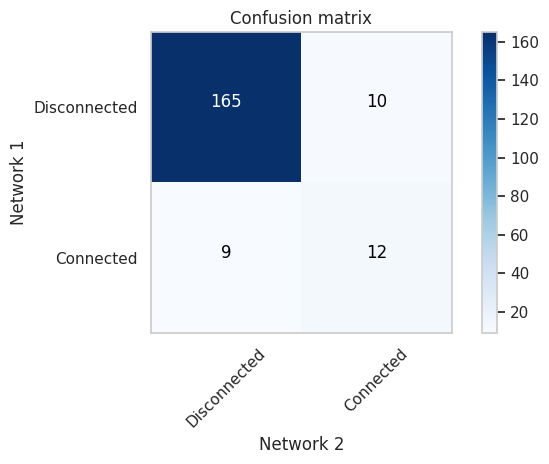

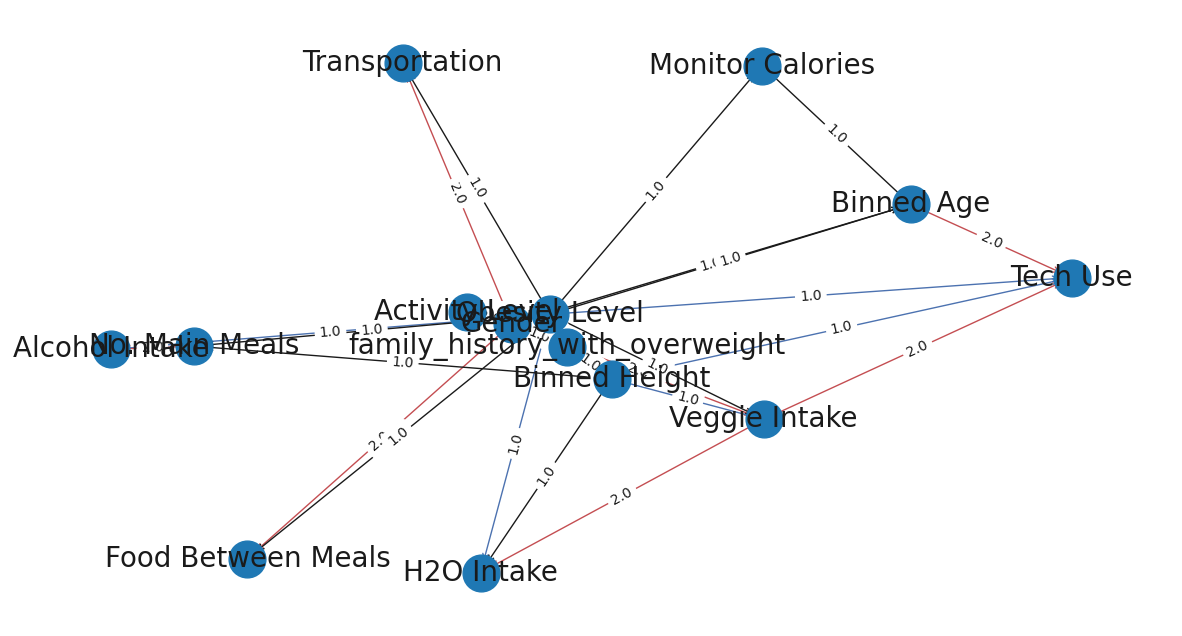

(array([[165,  10],
        [  9,  12]]),
 target                          Gender  family_history_with_overweight  \
 source                                                                   
 Gender                               0                               0   
 family_history_with_overweight      -1                               0   
 Food Between Meals                   0                               0   
 Monitor Calories                     0                               0   
 Alcohol Intake                       0                               0   
 Transportation                       0                               0   
 Obesity Level                       -1                               0   
 Activity Level                       2                               0   
 Veggie Intake                        0                               0   
 No. Main Meals                       0                               0   
 H2O Intake                           0                   

In [ ]:
model = bn.structure_learning.fit(data_subset) 


bin_model = bn.structure_learning.fit(data_subset_bin)
bn.plot_graphviz(model)
bn.plot_graphviz(bin_model)
# G = bn.plot(model, params_static={'layout':'planar_layout'})
# bn.plot(bin_model, pos=G['pos'])
bn.compare_networks(model, bin_model)

Yes, binning the target variable changes the learned causal structure.

Some direct connections to the original detailed "Obesity Level" node may be lost or altered in the binned version. For example, variables like "Activity Level" or "Food Between Meals" may no longer directly connect to the binned obesity node because the model can’t capture fine-grained differences.

The structure changes because binning simplifies the outcome variable, which reduces the model's ability to detect subtle dependencies between variables and specific obesity categories. This loss of detail can weaken or eliminate causal links.